# Keras costs visualizations
In this notebook we will visualize different costs associated with different popular architectures

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import json
report_path = "dummy_06-22-18-36.timings.json"
with open(report_path) as file:
    report = json.load(file)

### Layer wise costs

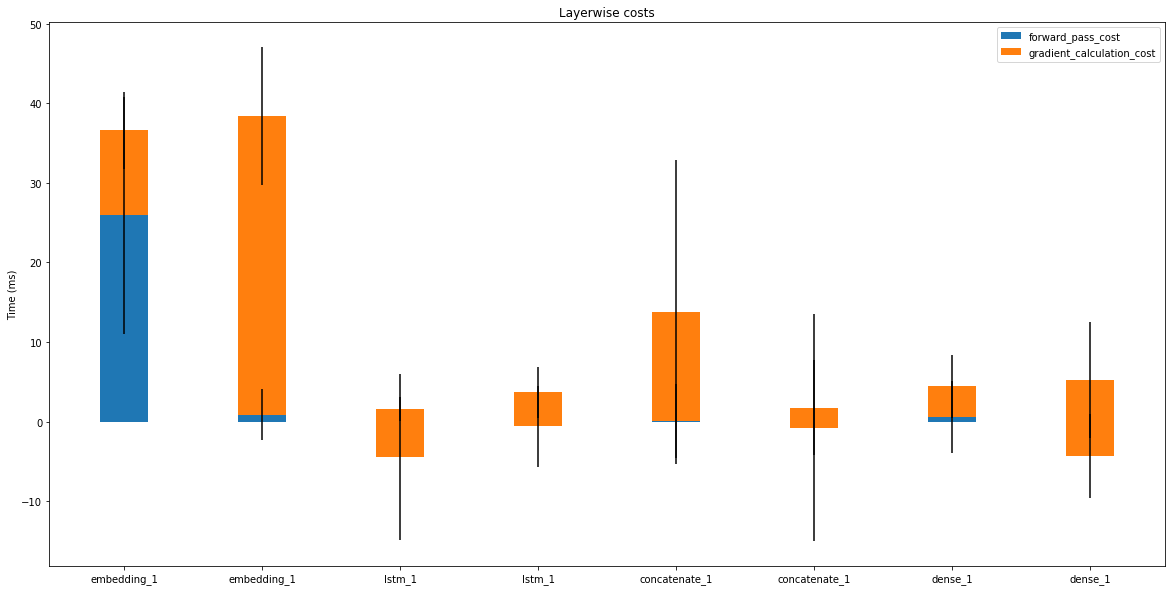

In [42]:
timings = report["timings"]
N = len(timings)
normalizing_factor = report["args"]["samples"] * 10**6 # Milliseconds instead of nano seconds
means = dict()
stds = dict()
xticks = list()
for layer_name in timings.keys():
    for cost_name in timings[layer_name].keys():
        if not cost_name.endswith("cost"):
            continue
        if cost_name not in means.keys():
            means[cost_name] = list()
        if cost_name not in stds.keys():
            stds[cost_name] = list()
        data = np.array(timings[layer_name][cost_name]) / normalizing_factor
        means[cost_name].append(np.mean(data))
        stds[cost_name].append(np.std(data))
        xticks.append(layer_name)

plt.figure(figsize=(20,10))
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
accumulated_means = np.zeros(shape=N)
for cost in means.keys():
    p = plt.bar(ind, means[cost], width, yerr=stds[cost], bottom=accumulated_means, label=cost)
    accumulated_means += means[cost]

plt.ylabel('Time (ms)')
plt.title('Layerwise costs')
plt.xticks(ind, xticks)
plt.legend()
plt.show()


### Layer type wise costs